In [57]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [58]:
edu = pd.read_csv('/Users/Vi/Documents/qbus6860/group/Education-services-au-export.csv',na_values=['np','unknown'])
reviews = pd.read_csv('/Users/Vi/Documents/qbus6860/group/edu_services_google_reviews.csv',na_values=['np','unknown'])

In [59]:
edu.head()

,ServiceApprovalNumber,Provider Approval Number,ServiceName,ProviderLegalName,ServiceType,ServiceAddress,Suburb,State,Postcode,Phone,...,Holiday Care Wednesday End Time,Holiday Care Thursday Start Time,Holiday Care Thursday End Time,Holiday Care Friday Start Time,Holiday Care Friday End Time,Holiday Care Saturday Start Time,Holiday Care Saturday End Time,Holiday Care Sunday Start Time,Holiday Care Sunday End Time,Temporarily Closed
0,SE-00000002,PR-00000898,Community Kids Waterford Early Education Centre,G8 Education Limited,Centre-Based Care,8-10 Allora St,WATERFORD WEST,QLD,4133.0,0732009852,...,18:15,06:15,18:15,06:15,18:15,NaN,NaN,NaN,NaN,No
1,SE-00000003,PR-40029099,KIDVENTURE EARLY LEARNING EAGLEBY,Table Mountain Trading Pty Ltd As The Trustee ...,Centre-Based Care,82 Fryar Road,EAGLEBY,QLD,4207.0,0738073222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2,SE-00000004,PR-00000898,Community Kids - Broadbeach Waters,G8 Education Limited,Centre-Based Care,4 Fremar Street,BROADBEACH WATERS,QLD,4217.0,0755920306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
3,SE-00000005,PR-40002184,Little Scholars School of Early Learning Burle...,The Scholars Group Pty Ltd,Centre-Based Care,143 Christine Ave,BURLEIGH WATERS,QLD,4220.0,0755353288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4,SE-00000006,PR-40029104,Small World Child Care Centre,A. & K. Massouras Pty. Ltd. ATF The A Massoura...,Centre-Based Care,113-115 Pappas Way,CARRARA,QLD,4211.0,07 5594 1844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [60]:
reviews.head()

,ServiceName,TitleShownOnGoogleMaps,overall_rating,5 stars,4 stars,3 stars,2 stars,1 stars,individual_rating,individual_comments
0,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,Sending our daughter to Chrysalis was the best...
1,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,Chrysalis is an incredible daycare centre for ...
2,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,"My child loves attending Chrysalis, often not ..."
3,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,I have had the pleasure of all 3 of my kids at...
4,Chrysalis Early Learning Centre,Chrysalis Early Learning Centre,4.8,58.0,3.0,0.0,0.0,3.0,5 stars,Our daughter has absolutely thrived during her...


In [61]:
edu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17663 entries, 0 to 17662
Data columns (total 97 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ServiceApprovalNumber                             17663 non-null  object 
 1   Provider Approval Number                          17663 non-null  object 
 2   ServiceName                                       17663 non-null  object 
 3   ProviderLegalName                                 17556 non-null  object 
 4   ServiceType                                       17663 non-null  object 
 5   ServiceAddress                                    17653 non-null  object 
 6   Suburb                                            17653 non-null  object 
 7   State                                             17653 non-null  object 
 8   Postcode                                          17653 non-null  float64
 9   Phone            

In [62]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29427 entries, 0 to 29426
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ServiceName             29427 non-null  object 
 1   TitleShownOnGoogleMaps  29427 non-null  object 
 2   overall_rating          29427 non-null  float64
 3   5 stars                 29248 non-null  float64
 4   4 stars                 29248 non-null  float64
 5   3 stars                 29248 non-null  float64
 6   2 stars                 29248 non-null  float64
 7   1 stars                 29248 non-null  float64
 8   individual_rating       29427 non-null  object 
 9   individual_comments     23321 non-null  object 
dtypes: float64(6), object(4)
memory usage: 2.2+ MB


In [63]:
edu_subset = edu[[
    'ServiceName',
    'OverallRating',
    'ServiceType',
    'Suburb',
    'State',
    'NumberOfApprovedPlaces'
]]

# 3. 合并（一比一复刻 listings 示例的模式）
df = reviews.rename(columns={
        'individual_comments': 'comments'
    }).merge(
    edu_subset,
    left_on='ServiceName',
    right_on='ServiceName',
    how='left'
)

# 4. 挑选最终要保留的列
df = df[[
    'ServiceName',
    'comments',
    'TitleShownOnGoogleMaps',
    'overall_rating',
    'OverallRating',
    'ServiceType',
    'Suburb',
    'State',
    'NumberOfApprovedPlaces'
]]
df['overall_rating']=pd.to_numeric(df['overall_rating'],errors = 'coerce')
df['NumberOfApprovedPlaces'] = pd.to_numeric(df['NumberOfApprovedPlaces'],errors = 'coerce')
df['comments']=df['comments'].astype(str)

# 5. 去掉没有评论文本的行

df.dropna(subset=['comments'], inplace=True)

# 6. 预览结果
df.head()

,ServiceName,comments,TitleShownOnGoogleMaps,overall_rating,OverallRating,ServiceType,Suburb,State,NumberOfApprovedPlaces
0,Chrysalis Early Learning Centre,Sending our daughter to Chrysalis was the best...,Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0
1,Chrysalis Early Learning Centre,Chrysalis is an incredible daycare centre for ...,Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0
2,Chrysalis Early Learning Centre,"My child loves attending Chrysalis, often not ...",Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0
3,Chrysalis Early Learning Centre,I have had the pleasure of all 3 of my kids at...,Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0
4,Chrysalis Early Learning Centre,Our daughter has absolutely thrived during her...,Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30057 entries, 0 to 30056
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ServiceName             30057 non-null  object 
 1   comments                30057 non-null  object 
 2   TitleShownOnGoogleMaps  30057 non-null  object 
 3   overall_rating          30057 non-null  float64
 4   OverallRating           28166 non-null  object 
 5   ServiceType             30057 non-null  object 
 6   Suburb                  30057 non-null  object 
 7   State                   30057 non-null  object 
 8   NumberOfApprovedPlaces  29771 non-null  float64
dtypes: float64(2), object(7)
memory usage: 2.1+ MB


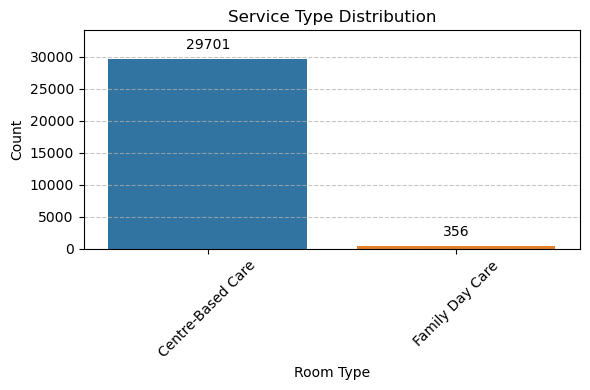

In [65]:
plt.figure(figsize=(6, 4))
order = df['ServiceType'].value_counts().index
ax = sns.countplot(data=df, x='ServiceType', order=order)
max_count = df['ServiceType'].value_counts().max()
ax.set_ylim(0, max_count * 1.15)
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=5)
sns.countplot(data=df, x='ServiceType', order=df['ServiceType'].value_counts().index)
plt.title("Service Type Distribution")
plt.ylabel("Count")
plt.xlabel("Room Type")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

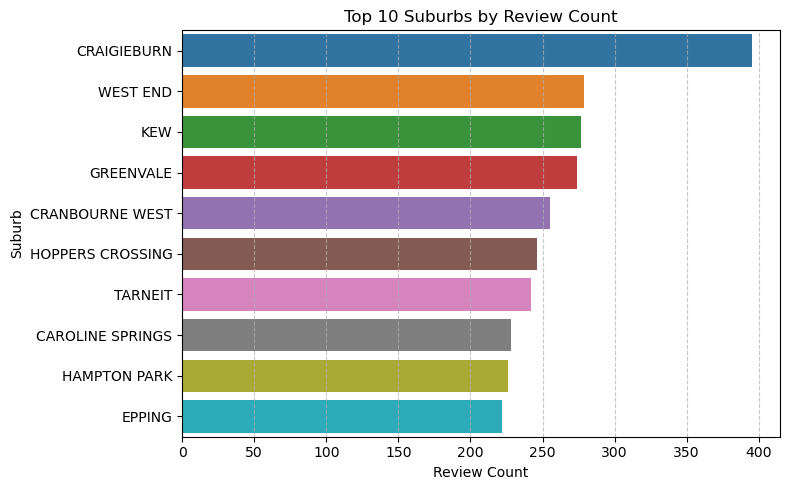

In [66]:
plt.figure(figsize=(8, 5))
top_sub = df['Suburb'].value_counts().nlargest(10)
sns.barplot(x=top_sub.values, y=top_sub.index)
plt.title("Top 10 Suburbs by Review Count")
plt.xlabel("Review Count")
plt.ylabel("Suburb")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'KEW'),
  Text(1, 0, 'CRANBOURNE WEST'),
  Text(2, 0, 'CRAIGIEBURN'),
  Text(3, 0, 'GREENVALE'),
  Text(4, 0, 'WEST END')])

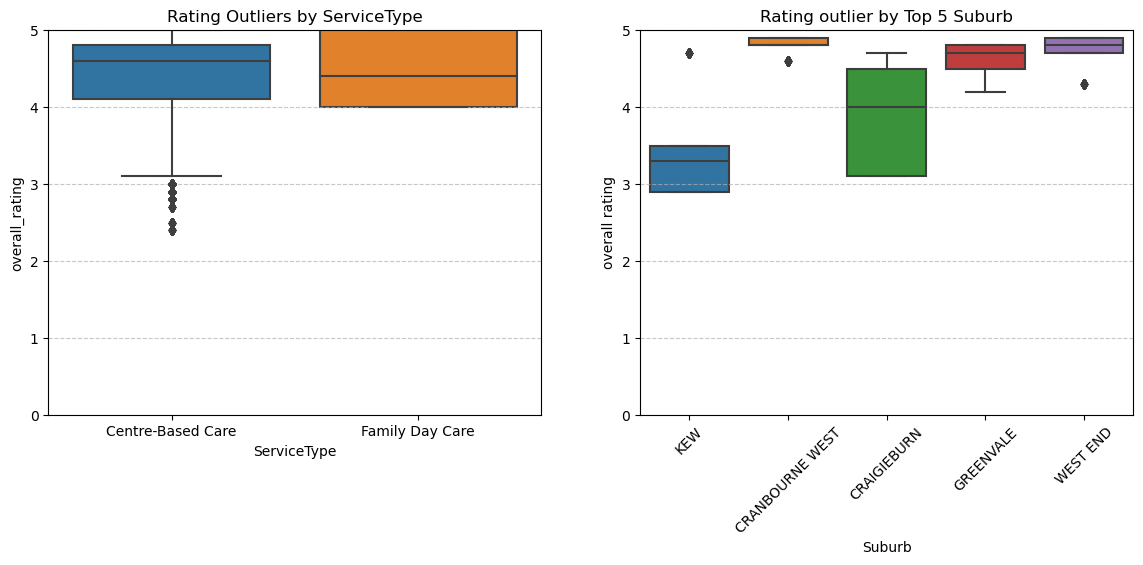

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By room type
sns.boxplot(data=df, x='ServiceType', y='overall_rating', ax=axes[0])
axes[0].set_title("Rating Outliers by ServiceType")
axes[0].set_xlabel("ServiceType")
axes[0].set_ylabel("overall_rating")
axes[0].set_ylim(0, df['overall_rating'].quantile(0.99))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# By top 5 neighbourhoods
top5_neigh = df['Suburb'].value_counts().nlargest(5).index
sns.boxplot(data=df[df['Suburb'].isin(top5_neigh)], x='Suburb', y='overall_rating', ax=axes[1])
axes[1].set_title("Rating outlier by Top 5 Suburb")
axes[1].set_xlabel("Suburb")
axes[1].set_ylabel("overall rating")
axes[1].set_ylim(0, df['overall_rating'].quantile(0.99))
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

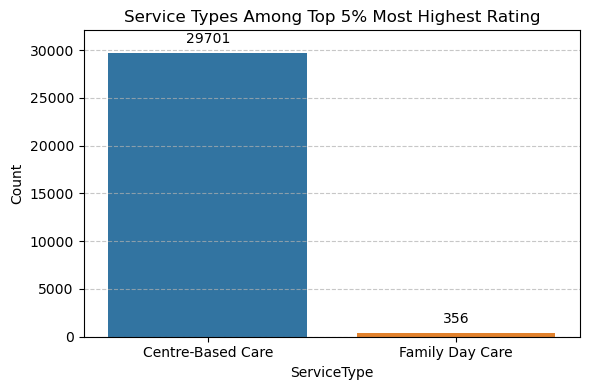

In [68]:
top_5_percent_threshold = df['overall_rating'].quantile(0.95)
top_outliers = df[df['overall_rating'] >= top_5_percent_threshold]

# Room type distribution in top 5%
plt.figure(figsize=(6, 4))
order = df['ServiceType'].value_counts().index
ax = sns.countplot(data=df, x='ServiceType', order=order)
max_count = df['ServiceType'].value_counts().max()
ax.set_ylim(0, max_count * 1.08)
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=5)
sns.countplot(data=top_outliers, x='ServiceType', order=top_outliers['ServiceType'].value_counts().index)
plt.title("Service Types Among Top 5% Most Highest Rating")
plt.xlabel("ServiceType")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [69]:
def clean_text(text):
    return re.sub(r"[^a-zA-Z\s]", "", text).lower().strip()

df['cleaned_review'] = df['comments'].apply(clean_text)
df[['comments', 'cleaned_review']].head()

,comments,cleaned_review
0,Sending our daughter to Chrysalis was the best...,sending our daughter to chrysalis was the best...
1,Chrysalis is an incredible daycare centre for ...,chrysalis is an incredible daycare centre for ...
2,"My child loves attending Chrysalis, often not ...",my child loves attending chrysalis often not w...
3,I have had the pleasure of all 3 of my kids at...,i have had the pleasure of all of my kids att...
4,Our daughter has absolutely thrived during her...,our daughter has absolutely thrived during her...


In [70]:
!pip install langdetect
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

In [71]:
# This is accuare solution but time-consuming, if you have a large dataset, or if you want to run in limited time, use the function is_likely_english instead of is_english

# !pip install langdetect
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False
    
def is_likely_english(text):
    # Keep if more than 80% of characters are basic English letters/spaces
    return len(re.findall(r"[a-zA-Z\s]", text)) / max(len(text), 1) > 0.8

# df = df[df['cleaned_review'].apply(is_english)]
df = df[df['cleaned_review'].apply(is_likely_english)]

In [72]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# !pip install nltk
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")

def stem_text(text):
    return " ".join([stemmer.stem(word) for word in text.split() if word not in ENGLISH_STOP_WORDS])

df['stemmed_review'] = df['cleaned_review'].apply(stem_text)
df[['cleaned_review', 'stemmed_review']].head()


,cleaned_review,stemmed_review
0,sending our daughter to chrysalis was the best...,send daughter chrysali best decis littl langua...
1,chrysalis is an incredible daycare centre for ...,chrysali incred daycar centr kid uniqu person ...
2,my child loves attending chrysalis often not w...,child love attend chrysali want stop play pick...
3,i have had the pleasure of all of my kids att...,pleasur kid attend chrysali like extend famili...
4,our daughter has absolutely thrived during her...,daughter absolut thrive time chrysali staff gr...


In [73]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 3), max_features=1000)
X_tfidf = vectorizer.fit_transform(df['stemmed_review'])
X_tfidf.shape

(30041, 1000)

In [74]:
from sklearn.cluster import KMeans

num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)
df['cluster'] = clusters
feature_names = vectorizer.get_feature_names_out()
top_keywords_per_cluster = []
for i in range(num_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    top_indices = cluster_center.argsort()[::-1][:6]
    top_keywords = [feature_names[j] for j in top_indices]
    top_keywords_per_cluster.append(top_keywords)
    print(f"Cluster {i} Keywords:", ", ".join(top_keywords))
for i in range(num_clusters):
    sample = df[df['cluster'] == i].iloc[0]
    print(f"\n--- Sample Review from Cluster {i} ---")
    print(sample['comments'])

Cluster 0 Keywords: child care, child care centr, care centr, best child, best child care, high recommend
Cluster 1 Keywords: high recommend, absolut love, year old, earli learn, staff friend, friend staff
Cluster 2 Keywords: reliabl qualiti, posit respons, reliabl qualiti profession, qualiti profession, respons reliabl, respons reliabl qualiti
Cluster 3 Keywords: staff help, help friend, birthday parti, high recommend, friend staff, great staff

--- Sample Review from Cluster 0 ---
We were very impressed by the premises on our first “show us around” visit earlier this year. The whole building is an architectural designed with passive natural ventilation and oriented to the ultimate fit to the purpose of “child care center” where you can oversee almost every part of the playground but still let the logical people and traffic flow in play due to its unique donut shaped layout. I would suggest parents to experience themselves in the pick up and drop off routine and see how an complete pu

In [137]:
aedc = '/Users/Vi/Documents/qbus6860/group/LGA 2009-21(AEDC).xlsx'
sheet_name = 'LGA One or more'
aedc_raw = pd.read_excel(aedc,sheet_name = 'LGA One or more',skiprows = 5)
aedc_raw = aedc_raw.drop(aedc_raw.columns[0],axis = 1)
aedc_raw = aedc_raw.drop(aedc_raw.columns[2:8],axis=1)
aedc_raw = aedc_raw.drop(aedc_raw.columns[[3,5,7,9]],axis=1)

remove_state = ['New South Wales','Victoria','Queensland',
               'Western Australia','South Australia',
               'Tasmania','Australian Capital Territory','Northern Territory']
aedc_raw = aedc_raw[~aedc_raw['Code'].astype(str).isin(remove_state)]
               
aedc_raw = aedc_raw.dropna(how='all')
aedc_raw = aedc_raw.reset_index(drop=True)
aedc_raw = aedc_raw.drop(index=aedc_raw.index[548:556])
aedc_raw.columns = ['Code','Name','2009','2012','2015','2018','2021']

aedc_long_onemore =pd.melt(
  aedc_raw,
  id_vars=['Code','Name'],
  value_vars=['2009','2012','2015','2018','2021'],
  var_name='Year',
  value_name='Developmentally vulnerable on one or more')

aedc_long_onemore['Year'] = aedc_long_onemore['Year'].astype(int)
aedc_long_onemore = aedc_long_onemore.reset_index(drop=True)
aedc_long_onemore

,Code,Name,Year,Developmentally vulnerable on one or more
0,10050,Albury,2009,23.339012
1,10180,Armidale Regional,2009,25.925926
2,10250,Ballina,2009,24.8394
3,10300,Balranald,2009,16.129032
4,10470,Bathurst Regional,2009,23.142251
...,...,...,...,...
2735,74560,Wagait,2021,*
2736,74660,West Arnhem,2021,*
2737,74680,West Daly,2021,71.186441
2738,79399,Unincorporated NT,2021,23.75


In [138]:
aedc = '/Users/Vi/Documents/qbus6860/group/LGA 2009-21(AEDC).xlsx'
sheet_name = 'LGA Two or more'
aedc_raw = pd.read_excel(aedc,sheet_name = 'LGA Two or more',skiprows = 5)
aedc_raw = aedc_raw.drop(aedc_raw.columns[0],axis = 1)
aedc_raw = aedc_raw.drop(aedc_raw.columns[2:8],axis=1)
aedc_raw = aedc_raw.drop(aedc_raw.columns[[3,5,7,9]],axis=1)

remove_state = ['New South Wales','Victoria','Queensland',
               'Western Australia','South Australia',
               'Tasmania','Australian Capital Territory','Northern Territory']
aedc_raw = aedc_raw[~aedc_raw['Code'].astype(str).isin(remove_state)]
               
aedc_raw = aedc_raw.dropna(how='all')
aedc_raw = aedc_raw.reset_index(drop=True)
aedc_raw = aedc_raw.drop(index=aedc_raw.index[548:556])
aedc_raw.columns = ['Code','Name','2009','2012','2015','2018','2021']

aedc_long_twomore =pd.melt(
  aedc_raw,
  id_vars=['Code','Name'],
  value_vars=['2009','2012','2015','2018','2021'],
  var_name='Year',
  value_name='Developmentally vulnerable on two or more')

aedc_long_twomore['Year'] = aedc_long_twomore['Year'].astype(int)
aedc_long_twomore = aedc_long_twomore.reset_index(drop=True)
aedc_long_twomore

,Code,Name,Year,Developmentally vulnerable on two or more
0,10050,Albury,2009,12.776831
1,10180,Armidale Regional,2009,14.814815
2,10250,Ballina,2009,10.8742
3,10300,Balranald,2009,9.677419
4,10470,Bathurst Regional,2009,11.677282
...,...,...,...,...
2735,74560,Wagait,2021,*
2736,74660,West Arnhem,2021,*
2737,74680,West Daly,2021,52.542373
2738,79399,Unincorporated NT,2021,10


In [139]:
aedc_merged = pd.merge(aedc_long_onemore,aedc_long_twomore,on=['Code','Name','Year'],how='outer')
aedc_merged

,Code,Name,Year,Developmentally vulnerable on one or more,Developmentally vulnerable on two or more
0,10050,Albury,2009,23.339012,12.776831
1,10180,Armidale Regional,2009,25.925926,14.814815
2,10250,Ballina,2009,24.8394,10.8742
3,10300,Balranald,2009,16.129032,9.677419
4,10470,Bathurst Regional,2009,23.142251,11.677282
...,...,...,...,...,...
2735,74560,Wagait,2021,*,*
2736,74660,West Arnhem,2021,*,*
2737,74680,West Daly,2021,71.186441,52.542373
2738,79399,Unincorporated NT,2021,23.75,10


In [140]:
aedc_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740 entries, 0 to 2739
Data columns (total 5 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Code                                       2740 non-null   object
 1   Name                                       2740 non-null   object
 2   Year                                       2740 non-null   int64 
 3   Developmentally vulnerable on one or more  2740 non-null   object
 4   Developmentally vulnerable on two or more  2740 non-null   object
dtypes: int64(1), object(4)
memory usage: 107.2+ KB


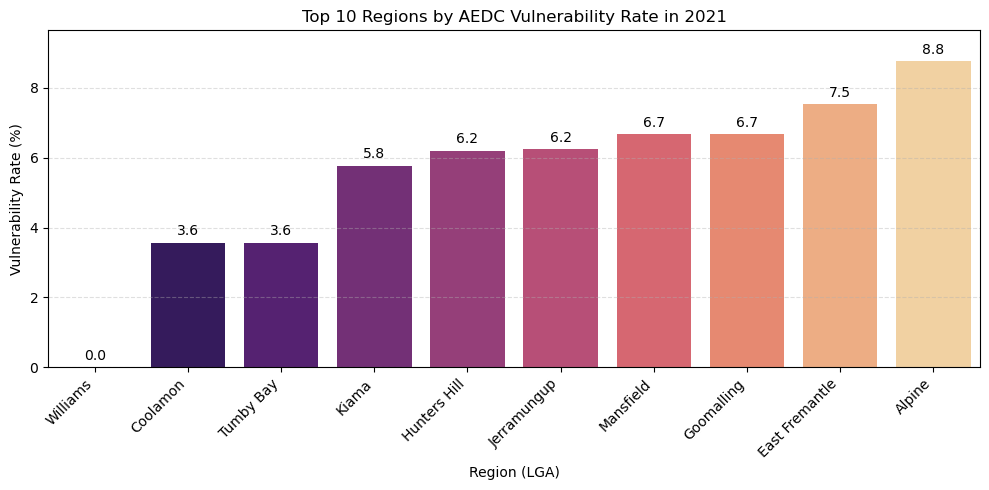

In [141]:
Year = 2021
df_vuln = aedc_merged[aedc_merged['Year'] == year].copy()
df_vuln['vuln_rate'] = pd.to_numeric(df_vuln['Developmentally vulnerable on one or more'], errors='coerce')
df_vuln = df_vuln.dropna(subset=['vuln_rate'])

# 4. 排序
df_top10 = df_vuln.sort_values(by='vuln_rate', ascending=True).head(10)

# —— 绘图 —— 
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_top10,
    x='Name',
    y='vuln_rate',
    palette='magma'
)

# 美化
ax.set_title(f"Top 10 Regions by AEDC Vulnerability Rate in {year}")
ax.set_xlabel("Region (LGA)")
ax.set_ylabel("Vulnerability Rate (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0, df_top10['vuln_rate'].max() * 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 在柱顶加标签
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.tight_layout()
plt.show()

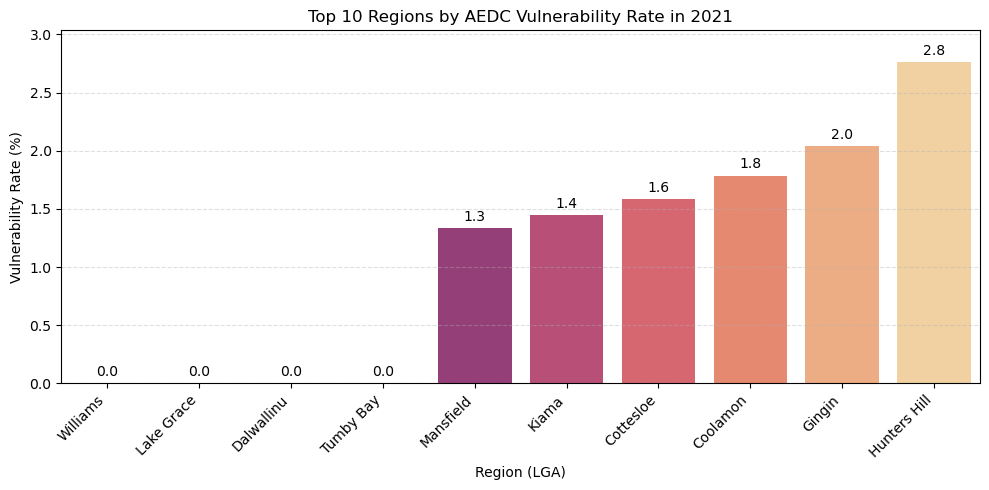

In [142]:
Year = 2021
df_vuln = aedc_merged[aedc_merged['Year'] == year].copy()
df_vuln['vuln_rate'] = pd.to_numeric(df_vuln['Developmentally vulnerable on two or more'], errors='coerce')
df_vuln = df_vuln.dropna(subset=['vuln_rate'])

# 4. 排序
df_top10 = df_vuln.sort_values(by='vuln_rate', ascending=True).head(10)

# —— 绘图 —— 
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=df_top10,
    x='Name',
    y='vuln_rate',
    palette='magma'
)

# 美化
ax.set_title(f"Top 10 Regions by AEDC Vulnerability Rate in {year}")
ax.set_xlabel("Region (LGA)")
ax.set_ylabel("Vulnerability Rate (%)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylim(0, df_top10['vuln_rate'].max() * 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 在柱顶加标签
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)

plt.tight_layout()
plt.show()

In [143]:
rating_bins = pd.qcut(df['overall_rating'], q=5, labels=['Significant Improvement Required', 'Working Towards NQS', 'Meeting NQS', 'Excellent NQS', 'Excellent'])
df['rating_category'] = rating_bins

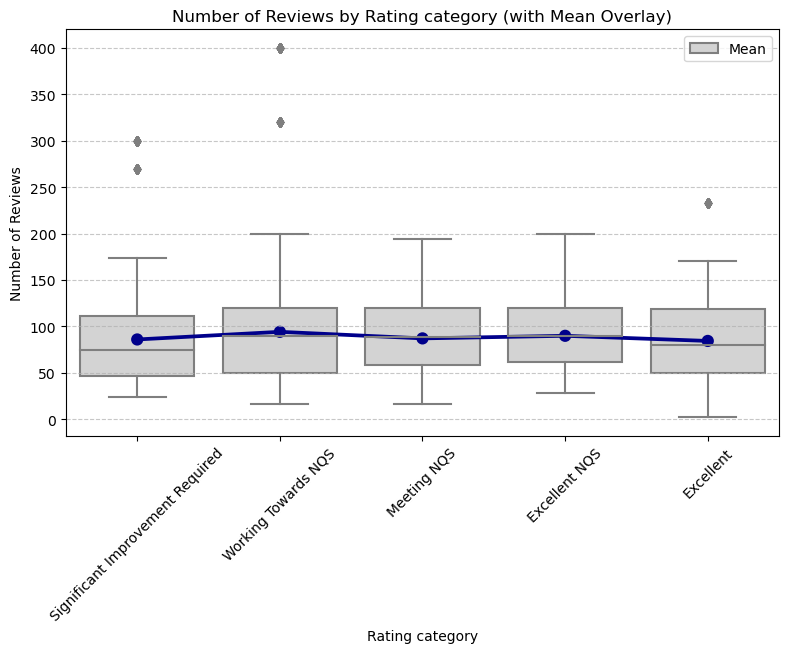

In [144]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='rating_category', y='NumberOfApprovedPlaces', color='lightgray')

# Compute medians for each price category
means = df.groupby('rating_category')['NumberOfApprovedPlaces'].mean().reindex(['Significant Improvement Required', 'Working Towards NQS', 'Meeting NQS', 'Excellent NQS', 'Excellent'])

# Overlay median line chart
sns.pointplot(x=means.index, y=means.values, color='darkblue', label='Median', linestyles='-', markers='o')

plt.title("Number of Reviews by Rating category (with Mean Overlay)")
plt.xlabel("Rating category")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(["Mean"])
plt.show()


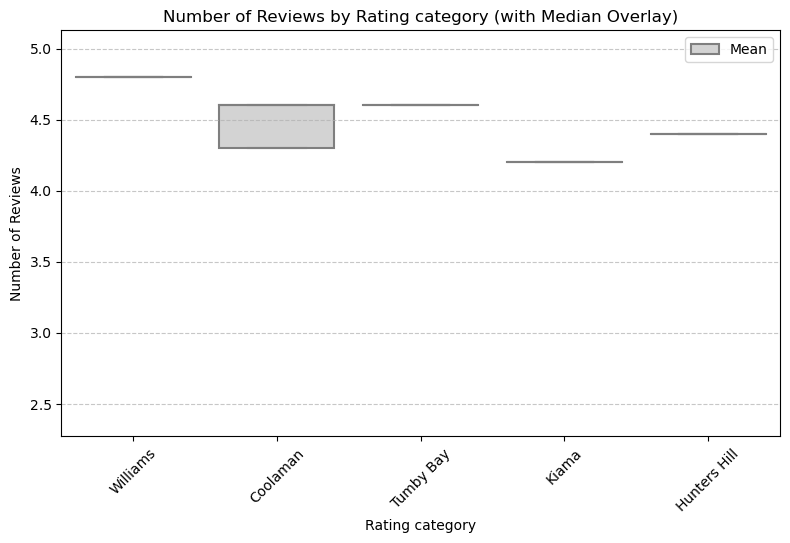

In [145]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Suburb', y='overall_rating', color='lightgray')

# Compute medians for each price category
means = df.groupby('Suburb')['overall_rating'].mean().reindex(['Williams', 'Coolaman', 'Tumby Bay', 'Kiama', 'Hunters Hill'])

# Overlay median line chart
sns.pointplot(x=means.index, y=means.values, color='darkblue', label='Mean', linestyles='-', markers='o')

plt.title("Number of Reviews by Rating category (with Median Overlay)")
plt.xlabel("Rating category")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(["Mean"])
plt.show()

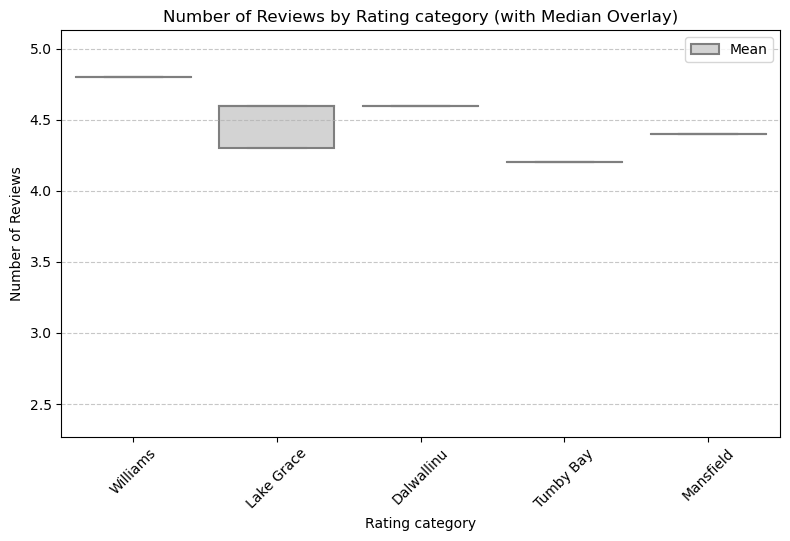

In [147]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Suburb', y='overall_rating', color='lightgray')

# Compute medians for each price category
means = df.groupby('Suburb')['overall_rating'].median().reindex(['Williams', 'Lake Grace', 'Dalwallinu', 'Tumby Bay', 'Mansfield'])

# Overlay median line chart
sns.pointplot(x=medians.index, y=medians.values, color='darkblue', label='Mean', linestyles='-', markers='o')

plt.title("Number of Reviews by Rating category (with Median Overlay)")
plt.xlabel("Rating category")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.xticks(rotation=45)
plt.legend(["Mean"])
plt.show()

In [148]:
df['suburb_clean'] = df['Suburb'].str.lower().str.strip()
aedc_merged['Name_clean'] = aedc_merged['Name'].str.lower().str.strip()

google_aedc = pd.merge(df,
                      aedc_merged[['Name_clean','Developmentally vulnerable on one or more',
                                   'Developmentally vulnerable on two or more']],
                      left_on = 'suburb_clean',
                      right_on = 'Name_clean',
                      how = 'left')
google_aedc

,ServiceName,comments,TitleShownOnGoogleMaps,overall_rating,OverallRating,ServiceType,Suburb,State,NumberOfApprovedPlaces,cleaned_review,...,cluster,rating_category,is_onemore,is_twomore,highlight1,highlight2,suburb_clean,Name_clean,Developmentally vulnerable on one or more,Developmentally vulnerable on two or more
0,Chrysalis Early Learning Centre,Sending our daughter to Chrysalis was the best...,Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0,sending our daughter to chrysalis was the best...,...,1,Excellent NQS,False,False,False,False,bundaberg,bundaberg,34.623218,19.489796
1,Chrysalis Early Learning Centre,Sending our daughter to Chrysalis was the best...,Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0,sending our daughter to chrysalis was the best...,...,1,Excellent NQS,False,False,False,False,bundaberg,bundaberg,29.385574,15.302491
2,Chrysalis Early Learning Centre,Sending our daughter to Chrysalis was the best...,Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0,sending our daughter to chrysalis was the best...,...,1,Excellent NQS,False,False,False,False,bundaberg,bundaberg,28.818182,15.942029
3,Chrysalis Early Learning Centre,Sending our daughter to Chrysalis was the best...,Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0,sending our daughter to chrysalis was the best...,...,1,Excellent NQS,False,False,False,False,bundaberg,bundaberg,33.75,20.944742
4,Chrysalis Early Learning Centre,Sending our daughter to Chrysalis was the best...,Chrysalis Early Learning Centre,4.8,Exceeding NQS,Centre-Based Care,BUNDABERG,QLD,100.0,sending our daughter to chrysalis was the best...,...,1,Excellent NQS,False,False,False,False,bundaberg,bundaberg,29.92126,16.617502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39784,Headstart Early Learning Centre Oatlands,nan,Headstart Early Learning Centre Oatlands,4.7,Meeting NQS,Centre-Based Care,OATLANDS,NSW,56.0,nan,...,1,Meeting NQS,False,False,False,False,oatlands,NaN,NaN,NaN
39785,Headstart Early Learning Centre Oatlands,nan,Headstart Early Learning Centre Oatlands,4.7,Meeting NQS,Centre-Based Care,OATLANDS,NSW,56.0,nan,...,1,Meeting NQS,False,False,False,False,oatlands,NaN,NaN,NaN
39786,Headstart Early Learning Centre Oatlands,nan,Headstart Early Learning Centre Oatlands,4.7,Meeting NQS,Centre-Based Care,OATLANDS,NSW,56.0,nan,...,1,Meeting NQS,False,False,False,False,oatlands,NaN,NaN,NaN
39787,Headstart Early Learning Centre Oatlands,nan,Headstart Early Learning Centre Oatlands,4.7,Meeting NQS,Centre-Based Care,OATLANDS,NSW,56.0,nan,...,1,Meeting NQS,False,False,False,False,oatlands,NaN,NaN,NaN


In [149]:
google_aedc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39789 entries, 0 to 39788
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   ServiceName                                39789 non-null  object  
 1   comments                                   39789 non-null  object  
 2   TitleShownOnGoogleMaps                     39789 non-null  object  
 3   overall_rating                             39789 non-null  float64 
 4   OverallRating                              37175 non-null  object  
 5   ServiceType                                39789 non-null  object  
 6   Suburb                                     39789 non-null  object  
 7   State                                      39789 non-null  object  
 8   NumberOfApprovedPlaces                     39503 non-null  float64 
 9   cleaned_review                             39789 non-null  object  
 10  stemmed_re

In [151]:
google_aedc['Developmentally vulnerable on one or more'] = pd.to_numeric(google_aedc['Developmentally vulnerable on one or more'], errors='coerce')
google_aedc['Developmentally vulnerable on two or more'] = pd.to_numeric(google_aedc['Developmentally vulnerable on two or more'],errors = 'coerce')

In [158]:
select_sub_dv1 = ['Williams', 'Coolaman', 'Tumby Bay', 'Kiama', 
                  'Hunters Hill','Jerramungup','Mansfield',
                  'Goomalling','East Fremantle','Alpine']

select_sub_dv2 = [Williams', 'Lake Grace', 'Dalwallinu', 'Tumby Bay',
                  'Mansfield','Kiama', 'Cottesloe','Coolamon',
                  'Gingin','Hunters Hill']

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))


sns.scatterplot(data = google_aedc.dropna(subset=['Developmentally vulnerable on one or more']),
               x='overall_rating',
               y='Developmentally vulnerable on one or more',
               hue= 'select_sub_dv1',
               alpha=0.7,ax=ax1)
ax1.set_title('Google Review Rating in Dv1')


sns.scatterplot(data = google_aedc.dropna(subset=['Developmentally vulnerable on two or more']),
               x='overall_rating',
               y='Developmentally vulnerable on two or more',
               hue= 'select_sub_dv2',
               alpha=0.7,ax=ax2)
ax2.set_title('Google Review Rating in Dv2')


plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Google Review Raring')
plt.ylabel('Dv2 Percentage')
plt.grid(True)
plt.tight_layout()
plt.show()

SyntaxError: unterminated string literal (detected at line 5) (2495268011.py, line 5)

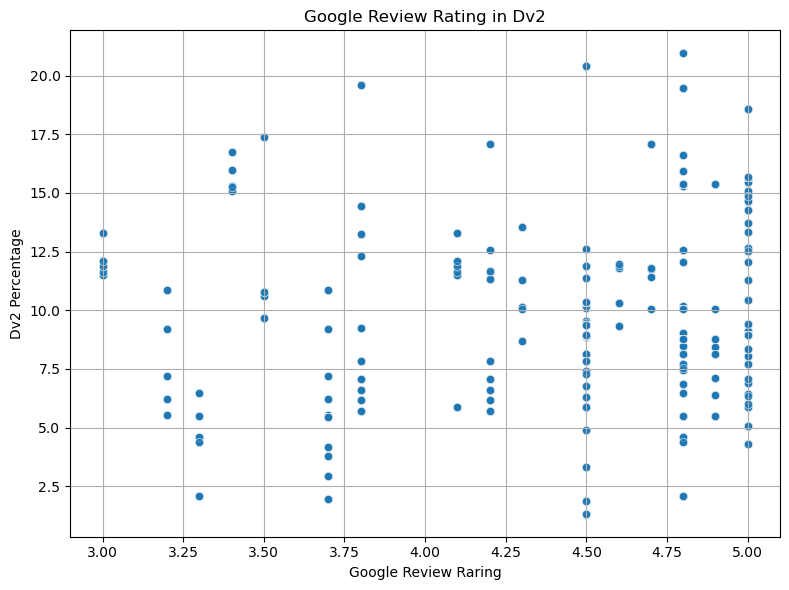

In [154]:
plt.figure(figsize=(8,6))
sns.scatterplot(data = google_aedc.dropna(subset=['Developmentally vulnerable on two or more']),
               x='overall_rating',
               y='Developmentally vulnerable on two or more',
               alpha=0.7)
plt.title('Google Review Rating in Dv2')
plt.xlabel('Google Review Raring')
plt.ylabel('Dv2 Percentage')
plt.grid(True)
plt.tight_layout()
plt.show()

In [120]:
room_types = df['room_type'].unique()
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

for ax, room in zip(axes.flat, room_types):
    subset = df[df['room_type'] == room]
    sns.boxplot(data=subset, x='price_category', y='number_of_reviews', ax=ax)
    medians = subset.groupby('price_category')['number_of_reviews'].median().reindex(['Budget', 'Affordable', 'Mid-Range', 'High-End', 'Premium', 'Luxury'])
    sns.pointplot(x=medians.index, y=medians.values, color='darkblue', ax=ax, markers='o', linestyles='-', label='Median')
    ax.set_title(f"{room} Listings")
    ax.set_xlabel("Price Category")
    ax.set_ylabel("Number of Reviews")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend().set_visible(False)

fig.suptitle("Number of Reviews by Price Tier for Each Room Type", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

KeyError: 'room_type'

# Q3

In [124]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

feature_names = vectorizer.get_feature_names_out()
tfidf_sum = X_tfidf.sum(axis=0)
top_indices = np.argsort(tfidf_sum.A1)[::-1][:100]
top_keywords = np.array(feature_names)[top_indices]

keyword_vectorizer = TfidfVectorizer()
keyword_vectors = keyword_vectorizer.fit_transform(top_keywords)

n_clusters = 5
kmeans_kw = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans_kw.fit_predict(keyword_vectors.toarray())

grouped_keywords = defaultdict(list)
for word, label in zip(top_keywords, labels):
    grouped_keywords[label].append(word)
    
for cluster_id, words in grouped_keywords.items():
     print(f"Cluster {cluster_id}: {', '.join(words)}")

Cluster 4: high recommend, absolut love, year old, child care, daughter love, month old, care children, kid love, day care, son love, good school, look forward, daughter attend, son attend, love care, care kid, feel like, come home, genuin care, love school, love place, definit recommend, custom servic, make feel, stori hous, warm welcom, make sure, best school, love teacher, children attend, send child, send kid, feel comfort, primari school, year ago, play area, nurtur environ, care love, feel welcom, care child, like famili, absolut amaz, environ children, place kid, school teacher, care attent, daughter start, children love, care provid, realli enjoy, realli care, feel safe
Cluster 0: qualiti profession, posit respons, reliabl qualiti, reliabl qualiti profession, respons reliabl, posit respons reliabl, respons reliabl qualiti, profession valu, qualiti profession valu
Cluster 2: earli learn, recommend centr, childcar centr, centr manag, love centr, attend centr, amaz centr, great ce